In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
annot = pd.read_csv(
    'data/viral_spectra_dataset.csv', 
    usecols=['Type','taxname','df','taxid','virusname']
).query('df == "nemu"')

annot['taxid'] = annot['taxid'].astype(int)
annot.set_index('taxid', inplace=True)
del annot['df']
annot.head()

,Type,taxname,virusname
taxid,,,
10407,ds,Hepatitis B virus,HBV
10990,ds,Rice black streaked dwarf virus,RBSDV
11082,+,West Nile virus,WNV
11983,+,Norwalk virus,norw
12092,+,Hepatovirus A,HAV


In [3]:
obs_aa_freqs = pd.read_csv('./data/aminoacid_freq_all_virus.csv', index_col=0)
    # .join(annot).dropna() # TODO remove dropna whan we update the dataset of amino acid frequencies???
del obs_aa_freqs['refseq_id']
del obs_aa_freqs['X']
print(obs_aa_freqs.shape)
aa_order = obs_aa_freqs.columns[:20]
obs_aa_freqs_long = obs_aa_freqs.melt(
    var_name='amino_acid', 
    value_name='obs_freq',
    ignore_index=False,
).reset_index()
obs_aa_freqs_long

(34, 20)


,taxid,amino_acid,obs_freq
0,10990,M,0.024014
1,11082,M,0.032028
2,11320,M,0.039465
3,1133363,M,0.031650
4,1157337,M,0.029342
...,...,...,...
675,54290,C,0.032718
676,57482,C,0.017490
677,693997,C,0.031864
678,694014,C,0.032858


In [4]:
# TODO recalc this table on new dataset
# TODO recalc OBS table for new dataset

eq_aa_freqs = pd.read_csv('./data/aminoacid_eq_freq_all_virus.csv', index_col=0)[aa_order]
eq_aa_freqs_long = eq_aa_freqs.melt(
    var_name='amino_acid', 
    value_name='eq_freq',
    ignore_index=False,
).reset_index()
eq_aa_freqs_long

,taxid,amino_acid,eq_freq
0,10990,M,0.010919
1,11082,M,0.021009
2,11320,M,0.020867
3,1133363,M,0.011300
4,1157337,M,0.012432
...,...,...,...
575,54290,C,0.042232
576,57482,C,0.036417
577,693997,C,0.034267
578,694014,C,0.041443


<Axes: xlabel='obs_freq', ylabel='eq_freq'>

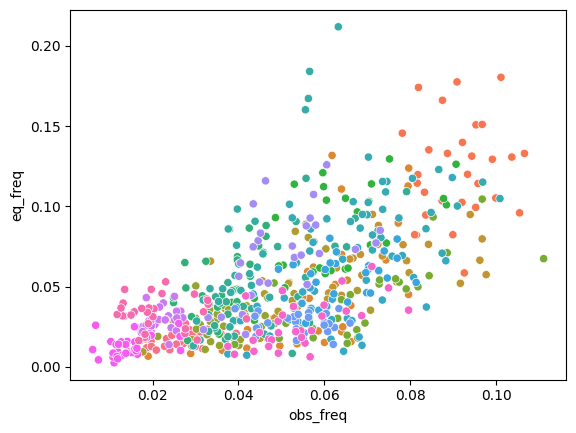

In [5]:
_df_compare = obs_aa_freqs_long.merge(eq_aa_freqs_long, how='inner', on=['taxid', 'amino_acid'])
sns.scatterplot(_df_compare, x='obs_freq', y='eq_freq', hue='amino_acid', legend=False)

In [6]:
eq_aa_freqs.index.intersection(obs_aa_freqs.index).shape, obs_aa_freqs.shape

((29,), (34, 20))

In [193]:
common_taxids = eq_aa_freqs.index\
    .intersection(obs_aa_freqs.index)\
        .intersection(annot.index)
eq_aa_freqs_sample = eq_aa_freqs.loc[common_taxids, aa_order]
obs_aa_freqs_sample = obs_aa_freqs.loc[common_taxids, aa_order]

In [194]:
from itertools import combinations

from scipy.stats import pearsonr, spearmanr

data = []
for t1, t2 in combinations(common_taxids, 2):
    t1_eq_aa_freqs = eq_aa_freqs.loc[t1, aa_order]
    t2_eq_aa_freqs = eq_aa_freqs.loc[t2, aa_order]
    t1_obs_aa_freqs = obs_aa_freqs.loc[t1, aa_order]
    t2_obs_aa_freqs = obs_aa_freqs.loc[t2, aa_order]

    obs_diff = (t1_obs_aa_freqs - t2_obs_aa_freqs)
    eq_diff = (t1_eq_aa_freqs - t2_eq_aa_freqs)

    rho, p = spearmanr(obs_diff, eq_diff)

    # obs_diff['taxid1'] = t1
    # obs_diff['taxid2'] = t2
    # eq_diff['taxid1'] = t1
    # eq_diff['taxid2'] = t2

    data.append([t1, t2, rho, p])

df = pd.DataFrame(data, columns=['taxid1', 'taxid2', 'spearmanr', 'spearman_pval'])
df['virusname1'] = df['taxid1'].map(annot['virusname'])
df['virusname2'] = df['taxid2'].map(annot['virusname'])
df['taxname1'] = df['taxid1'].map(annot['taxname'])
df['taxname2'] = df['taxid2'].map(annot['taxname'])
df['type1'] = df['taxid1'].map(annot['Type'])
df['type2'] = df['taxid2'].map(annot['Type'])
df = df.dropna()
df['pair'] = df.apply(lambda x: str(sorted([x['type1'], x['type2']])), axis=1)
df

,taxid1,taxid2,spearmanr,spearman_pval,virusname1,virusname2,taxname1,taxname2,type1,type2,pair
0,10990,11082,0.679699,0.000978,RBSDV,WNV,Rice black streaked dwarf virus,West Nile virus,ds,+,"['+', 'ds']"
1,10990,1133363,0.272180,0.245669,RBSDV,SBV,Rice black streaked dwarf virus,Schmallenberg orthobunyavirus,ds,-,"['-', 'ds']"
2,10990,1157337,0.669173,0.001253,RBSDV,PRV,Rice black streaked dwarf virus,Piscine orthoreovirus,ds,ds,"['ds', 'ds']"
3,10990,118655,0.339850,0.142637,RBSDV,OROV,Rice black streaked dwarf virus,Oropouche orthobunyavirus,ds,-,"['-', 'ds']"
4,10990,11983,0.781955,0.000046,RBSDV,norw,Rice black streaked dwarf virus,Norwalk virus,ds,+,"['+', 'ds']"
...,...,...,...,...,...,...,...,...,...,...,...
373,57482,694014,0.273684,0.242966,EBLV1,ACoV,European bat 1 lyssavirus,Avian coronavirus,-,+,"['+', '-']"
374,57482,77763,0.359398,0.119633,EBLV1,BAV,European bat 1 lyssavirus,Banna virus,-,ds,"['-', 'ds']"
375,693997,694014,0.099248,0.677189,alCoV1,ACoV,Alphacoronavirus 1,Avian coronavirus,+,+,"['+', '+']"
376,693997,77763,0.015038,0.949828,alCoV1,BAV,Alphacoronavirus 1,Banna virus,+,ds,"['+', 'ds']"


In [195]:
df.groupby('pair').spearmanr.agg(['mean', 'std', 'min', 'median', 'max'])\
    .sort_values('mean', ascending=False).round(2)

,mean,std,min,median,max
pair,,,,,
"['+', '-']",0.46,0.28,-0.23,0.51,0.93
"['+', '+']",0.46,0.29,-0.34,0.52,0.90
"['ds', 'ds']",0.46,0.34,-0.29,0.60,0.82
"['+', 'ds']",0.41,0.29,-0.55,0.44,0.83
"['-', 'ds']",0.34,0.27,-0.29,0.36,0.73
"['-', '-']",0.20,0.38,-0.57,0.29,0.75


<Axes: xlabel='pair', ylabel='spearmanr'>

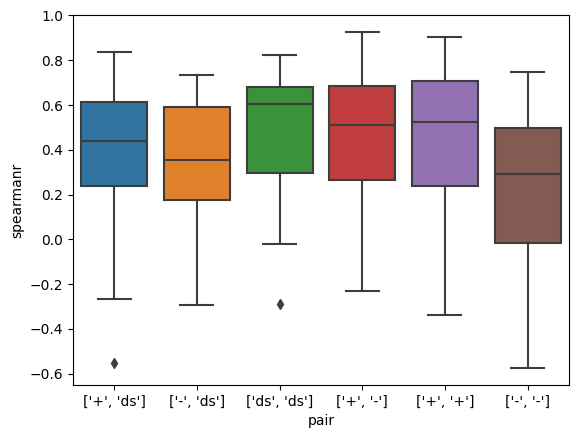

In [19]:
sns.boxplot(
    data=df,
    x='pair',
    y='spearmanr',
)

### compare with spectrum

In [204]:
from scipy.spatial.distance import pdist, squareform

spectrum = pd.read_csv('data/viral_spectra_dataset.csv')\
    .query('df == "nemu"').set_index(['taxid'])
spectrum.index = spectrum.index.astype(int)
cossim = pd.DataFrame(1-squareform(pdist(spectrum.iloc[:, :12], metric='cosine')), 
             index=spectrum.index,
             columns=spectrum.index)

In [207]:
df['cossim'] = df.apply(lambda x: cossim.loc[x['taxid1'], x['taxid2']], axis=1)

In [211]:
df[[ 'spearmanr', 'cossim']].corr(method='spearman').round(2)

,spearmanr,cossim
spearmanr,1.00,-0.45
cossim,-0.45,1.00


<Axes: xlabel='spearmanr', ylabel='cossim'>

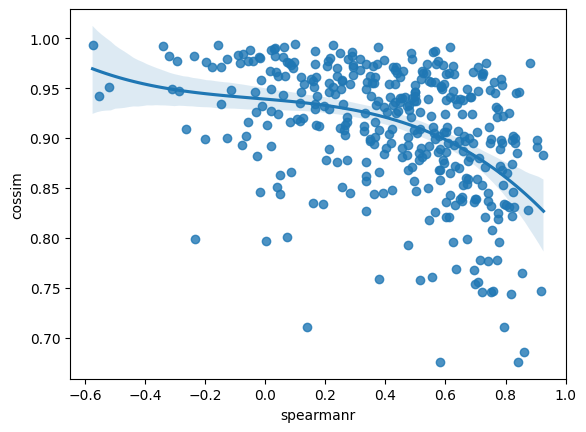

In [224]:
sns.regplot(df, x='spearmanr',  y='cossim', order=3)

In [210]:
df.sort_values('spearmanr', ascending=False).head(15)[
    ['virusname1', 'virusname1', 'taxname1', 'taxname2', 'pair', 'spearmanr', 'cossim']
]

,virusname1,virusname1,taxname1,taxname2,pair,spearmanr,cossim
289,aka,aka,Akabane orthobunyavirus,Porcine reproductive and respiratory syndrome ...,"['+', '-']",0.926316,0.882537
295,aka,aka,Akabane orthobunyavirus,GB virus C,"['+', '-']",0.917293,0.746232
243,evD,evD,Enterovirus D,Orthohepevirus A,"['+', '+']",0.903759,0.891410
237,evC,evC,Enterovirus C,GB virus C,"['+', '+']",0.903759,0.897665
214,evA,evA,Enterovirus A,Porcine reproductive and respiratory syndrome ...,"['+', '+']",0.881203,0.975133
202,denv,denv,Dengue virus,GB virus C,"['+', '+']",0.875188,0.828324
268,HMV,HMV,Human metapneumovirus,GB virus C,"['+', '-']",0.860150,0.685151
120,OROV,OROV,Oropouche orthobunyavirus,GB virus C,"['+', '-']",0.854135,0.764416
324,PRRSV,PRRSV,Porcine reproductive and respiratory syndrome ...,Rice stripe tenuivirus,"['+', '-']",0.845113,0.946529
73,SBV,SBV,Schmallenberg orthobunyavirus,GB virus C,"['+', '-']",0.840602,0.675832


## LDA

In [146]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

common_taxids = eq_aa_freqs.index\
    .intersection(obs_aa_freqs.index)\
        .intersection(annot.index)

eq_aa_freqs_sample = eq_aa_freqs.loc[common_taxids, aa_order]
obs_aa_freqs_sample = obs_aa_freqs.loc[common_taxids, aa_order]

X = obs_aa_freqs_sample
y = annot.loc[common_taxids].Type

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

obs_lda = pd.DataFrame(lda.transform(obs_aa_freqs_sample), 
                       columns=['LDA1', 'LDA2'], 
                       index=obs_aa_freqs_sample.index)
eq_lda = pd.DataFrame(lda.transform(eq_aa_freqs_sample), 
                      columns=['LDA1', 'LDA2'], 
                      index=eq_aa_freqs_sample.index)
obs_lda['Type'] = y.astype('category')
eq_lda['Type'] = y.astype('category')

In [147]:
lda.score(X, y)

1.0

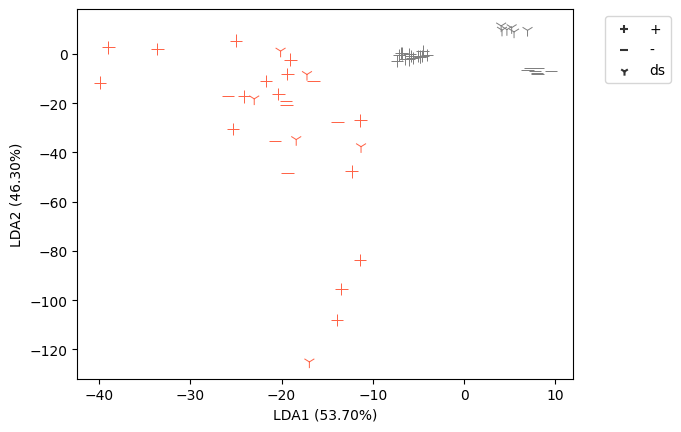

In [148]:
ax = sns.scatterplot(obs_lda, x='LDA1', y='LDA2', style='Type', 
                     markers=['+', '_', '1'], s=80, color='gray')
ax = sns.scatterplot(eq_lda, x='LDA1', y='LDA2', style='Type', 
                     markers=['+', '_', '1'], s=80, color='tomato', ax=ax, legend=False)
# ax.scatter(eq_lda['LDA1'], eq_lda['LDA2'], marker=eq_lda['Type'].cat.codes, c='r', cmap='Set1')
ax.set_xlabel(f"LDA1 ({lda.explained_variance_ratio_[0]:.2%})")
ax.set_ylabel(f"LDA2 ({lda.explained_variance_ratio_[1]:.2%})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.savefig('figures/lda_obs.png', bbox_inches='tight')
plt.show()

## PCA

In [150]:
pca.explained_variance_ratio_

array([5.00255490e-01, 1.38610581e-01, 1.12292242e-01, 7.42934556e-02,
       5.23649587e-02, 2.94442604e-02, 1.94662717e-02, 1.81323476e-02,
       1.59314214e-02, 1.11973743e-02, 7.88863204e-03, 6.02428519e-03,
       4.57557461e-03, 3.07708093e-03, 2.42248096e-03, 1.70870285e-03,
       1.03643777e-03, 8.58241002e-04, 4.19389170e-04, 7.72926609e-07])

In [151]:
from sklearn.decomposition import PCA

common_taxids = eq_aa_freqs.index\
    .intersection(obs_aa_freqs.index)\
        .intersection(annot.index)

eq_aa_freqs_sample = eq_aa_freqs.loc[common_taxids, aa_order]
obs_aa_freqs_sample = obs_aa_freqs.loc[common_taxids, aa_order]

X = obs_aa_freqs_sample
y = annot.loc[common_taxids].Type

pca = PCA(2)
pca.fit(X, y)

obs_pca = pd.DataFrame(pca.transform(obs_aa_freqs_sample), 
                       columns=['PC1', 'PC2'], 
                       index=obs_aa_freqs_sample.index)
eq_pca = pd.DataFrame(pca.transform(eq_aa_freqs_sample), 
                      columns=['PC1', 'PC2'], 
                      index=eq_aa_freqs_sample.index)
obs_pca['Type'] = y.astype('category')
eq_pca['Type'] = y.astype('category')

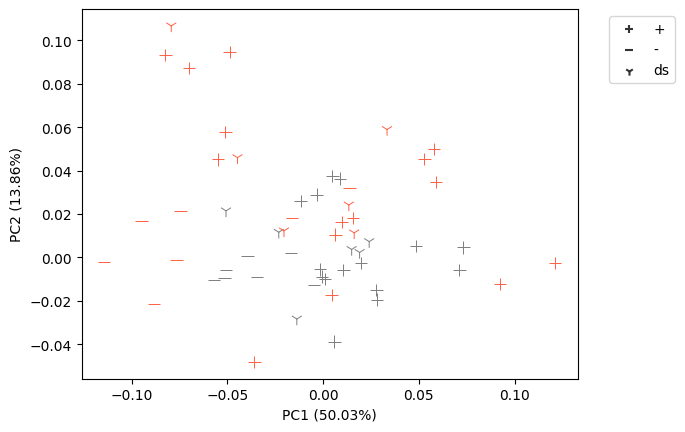

In [154]:
ax = sns.scatterplot(obs_pca, x='PC1', y='PC2', style='Type', 
                     markers=['+', '_', '1'], s=80, color='gray')
ax = sns.scatterplot(eq_pca, x='PC1', y='PC2', style='Type', 
                     markers=['+', '_', '1'], s=80, color='tomato', ax=ax, legend=False)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

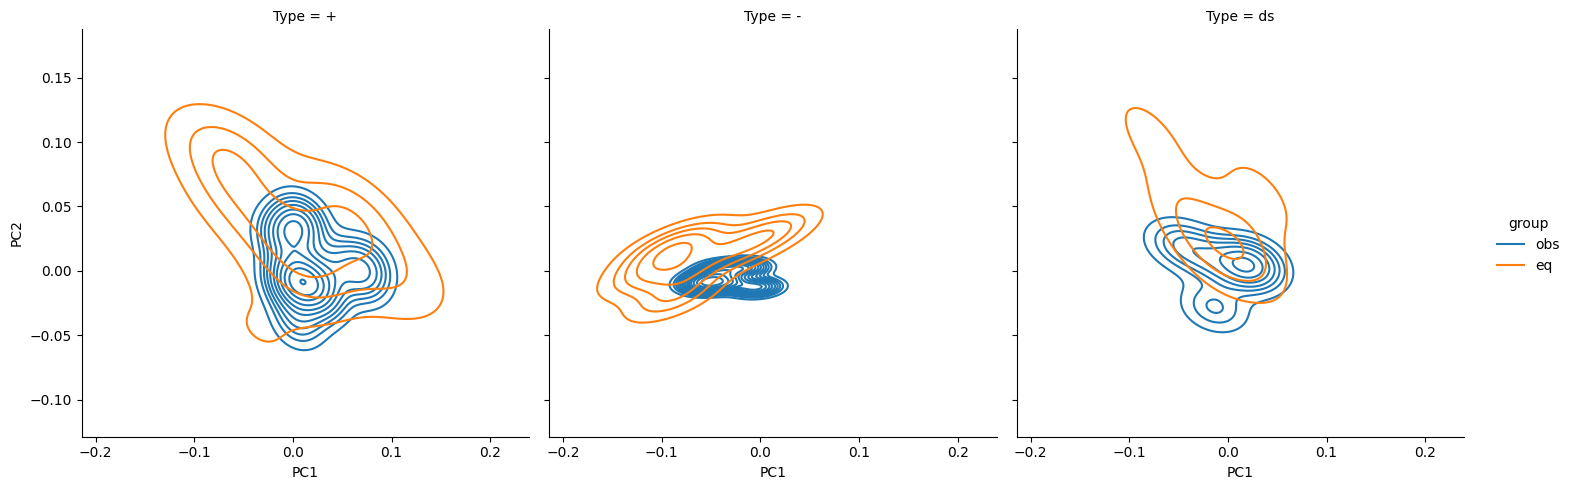

In [180]:
g = sns.displot(
    pd.concat([obs_pca.assign(group='obs'), eq_pca.assign(group='eq')]),
    x='PC1', y='PC2',
    hue='group',
    col='Type',
    kind='kde',
    levels=15, 
)